# Designing a Cruise Controller in Python #

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *

## Introduction ##

So you recently stumbled upon an amazing deal at your next door neighbor's house - a mint condition 1986 Toyota AE86 Sprinter Trueno! This is an exciting day - you're a huge weeb and have spent much of your life watching [Initial D](https://www.imdb.com/title/tt0385426/), so needless to say, you've wanted this car for a while. Unfortunately, you found out that there is no cruise control! Bummer. Well... good thing you know Python!



![alt text](./trueno.jpg "Toyota AE86 Sprinter Trueno")


## Open Loop Controller ##

So you start out with something pretty simple: a regular old open loop controller. You hear from your friend that you can model the speed as a direct function of the amount of the gas you put in, and only test this for a flat ground. You also have some reference speed that you are tracking. You learn from a friend that the output speed of the car is twice the input gas that you put in. Thus, you want to apply half the amount of pressure to the gas pedal as dictated by the reference speed. 

(INSERT PICTURE OF OPEN LOOP CONTROLLER HERE) <br />
$y = 2u$ <br />
$u = \frac{r}{2}$ <br />
$y_{ol} = r$ <br />


Unfortunately, the assumption that there is a 1:1 relationship between speed input from your sensors and the amount of gas you put in is incorrect, since the car is old, the fuel injector is pretty beat up, and the car is slightly out of alignment. It also doesn't take into account disturbances from, say, a rolling hill or the wind. Thus, the true model of the car can be found by:

(INSERT PICTURE OF ACTUAL OPEN LOOP CONTROLLER HERE) <br />
$y = u + d$ <br />
$y = \frac{r}{2} + d$

So, you will be losing 50% of your reference velocity, and all disturbances will be tracked as well. How do we fix this? Well, we close the loop!

## Closed Loop Controller ##

(INSERT PICTURE)

In the above picture, we directly take in the reference speed as an input and subtract the output velocity to get some measurement error $\epsilon$. We then tap into a tuned constant $K$ in order to scale it properly to the gas we want to apply in order to get the output velocity that we want. This is known as *Proportional Feedback*. 

We are now going to compute the true car model for the Proportional Feedback Controller. For now, we model the system with P, as shown below. We will also take into account disturbance.

(INSERT PICTURE WITH DISTURBANCE) <br />
$u = K\epsilon = K(r - y)$ <br />
$y_{cl} = Pu + d = PKr - PKy_{cl} + d$ <br />
$(I + PK)y_{cl} = PKr + d$ <br />
$y_{cl} = (I + PK)^{-1}(PKr + d)$

In our case, since we are assuming a one-dimensional model, we have the following equations: <br />
$u = K\epsilon = K(r - y)$ <br />
$y_{cl} = Pu + d = PKr - PKy_{cl} + d$ <br />
$(1 + PK)y_{cl} = PKr + d$ <br />
$y_{cl} = (1 + PK)^{-1}(PKr + d)$ <br />
$y_{cl} = \frac{PK}{1 + PK}r + \frac{1}{1 + PK}d$ <br />

We want the $\frac{PK}{1 + PK}$ to be as close to 1 as possible so that we can track the reference as well as we possibly can. Furthermore, we would like the $\frac{1}{1 + PK}$ to be as small as possible so that we can eliminate disturbances as much as we can. A large K, such as $K = 100$, should do the trick. If we assume $P = 1$, then we will track $\frac{100}{101}$ of the reference speed and $\frac{1}{101}$ of the disturbance, and will only be off by our reference speed by 1%. <br />

There is, of course, be limits to how big K can be (in our case, we are basically driving a rear-wheel-drive Corolla, so we can't accelerate too quickly), but we will talk about the limits of that in a bit.

## Comparing Open-Loop to Closed-Loop Systems ##

With the open loop system, we could not properly track disturbances, and so all disturbances fed straight through the system. With the closed loop system, this is no longer a problem, as disturbances are now properly accounted for and any inefficiencies with the car itself are tuned for. Let's take a look at the code to see what this looks like in practice. <br/>

We assume that our reference speed is 60 mph. We also assume that we are going through some rolling hills modeled by $10 sin(\pi t)$. In the models below, we assumed that P, or our model gain, was approximately 2. In reality the gain is actually 1. This means that there is an issue with how we track in the Open Loop controller. This is accounted for in the Closed Loop controller, so we're able to track the reference speed quite well. 

In [32]:
t = np.arange(0, 10, 0.1) # times that we care about

wr = 60.0 + 0.0*t # reference speed
d = 10*np.sin(np.pi*t) # disturbance

aModel = 2 # y = aModel*u
aTrue = 1. # y = aTrue*u

uOL = wr/aModel # Open Loop u based on model
yOL = aTrue*uOL + d # Open-Loop Response

K = 50 # Control gain, u = K(wr - y)
yCL = aTrue*K/(1.0 + aTrue*K)*wr + 1.0/(1 + aTrue*K)*d

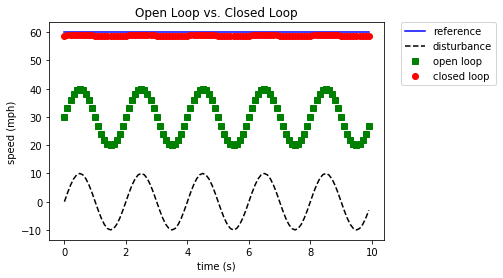

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# red dashes, blue squares and green triangles
plt.plot(t, wr, 'b', label="reference")
plt.plot(t, d, 'k--', label="disturbance")
plt.plot(t, yOL, 'gs', label="open loop")
plt.plot(t, yCL, 'ro', label="closed loop")
plt.title('Open Loop vs. Closed Loop')
plt.xlabel('time (s)')
plt.ylabel('speed (mph)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

It's kind of hard to see the reference speed vs. the closed loop speed. Let's take a closer look. As we can see below, the closed loop system tracks the reference speed quite well, but we could do a little bit better. Let's see what we can do. 

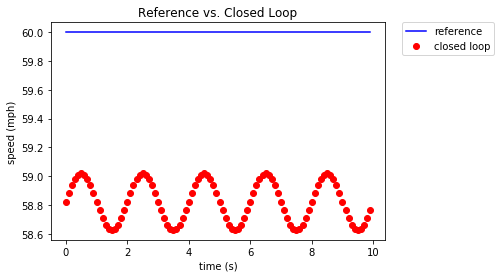

In [46]:
plt.plot(t, wr, 'b', label="reference")
plt.plot(t, yCL, 'ro', label="closed loop")
plt.title('Reference vs. Closed Loop')
plt.xlabel('time (s)')
plt.ylabel('speed (mph)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Proportional-Integral (PI) Control

As we saw in the above example, there was always a constant error in the Proportional Control System. This is due to the fact that now matter how large we make $K$, we will never completely follow $r$ due to the coefficient $\frac{PK}{1 + PK}$. Recall that we can't make K as large as we want due to the fact that we can't just dump an infinite amount of gas into the engine at once. This is where PI Control comes in. 

(HERE IS THE IMAGE) <br />

As can be seen in the image above, we still have our $K_p$ block. In addition to that, we are also a $K_I\int$ block which attempts to reduce the steady state error to 0. This means that we don't have to jack up the $K_p$ value to some insane number. Instead, we can use some moderate $K_p$ and still move the $\epsilon$ to 0. <br />

In addition to this, we made some crude assumptions about the car in general in our original model by assuming that $y = u$ and $P = 1$. Instead, let us assume the following model: <br />

$\dot{x} = -x + u$ <br />
$y = x$ <br />

In the above example, $u$ is still the inputted gas/brake, $y$ is still the speed of the car, and $x$ represents the dynamics that represents the speed as well, but also takes into account things like inertia. We can also write this as <br />

$\frac{\bar{y(s)}}{\bar{u(s)}} = P(s) = \frac{1}{s + 1}$ <br />

If we solve for this system, we will get that the result is something like $y = (e^{-t} \circledast u)(t) = \int_{\tau = 0}^{\infty} e^{\tau - t}u(\tau)d\tau$. If you don't know what this means, don't worry about it too much. <br/>



This will mean that the result will look like this: <br />

(GRAPH OF U) <br />
(GRAPH OF Y) <br />

Quantifying this, we get that from the above dynamics equations and block diagrams, that <br />
$u = K_p(r - y) + K_I\int(r - y)dt$ <br/>
The above integral captures the error term. We need to be able to capture the integral of error terms by using the states we have access to. 

We want to be able to represent the integral model for u in state space. Thus, we want to find some variable $z$ to keep track of the error term. The variable z captures this error term. We need to keep track of this error term. Thus, in addition to the $\dot{z}$, we will also need a $\dot{x}$ term, as both states are dynamic. <br />

$\dot{x} = -x - K_Px + K_Iz - K_Pr$ <br/>
$\dot{z} = r - y = r - x$ (if you remember, $y = x$) <br/>
$u = K_P(r - x) + K_Iz$ <br/>

We get the following state space models: <br/>
(INSERT MATRIX EQUATIONS HERE)

Now, it's time to compare plain old Proportional Feedback with Proportional-Integral control! Let's first start off by representing our Proportional Feedback Control System. In this model, we assume that we just jump our input gas to unit u, and then 

In [7]:
K = 5

sysCar = ss(-1, 1, 1, 0) # represents x_dot = -x + u, y = x
sysPROP = ss(-1-K, K, 1, 0) # represents x = (-1-K_p)*x + K_I*z, y = x

t = np.arange(0, 10, 0.1) # times that we care about
yCAR, tCAR = step(sysCar, t)
yPROP, tPROP = step(sysPROP, t)

We also take a look at the Proportional-Integral Controller and see what that does to our system. Recall the equation that we came up with for the aforementioned PI Control Matrix System. 

In [19]:
A = np.matrix([[-1-K, K], [-1, 0]])
B = np.matrix([[K], [1]])
C = np.matrix([[1, 0]])
D = 0

sysPI = ss(A, B, C, D)

t = np.arange(0, 10, 0.1) # times that we care about
yPI, tPI = step(sysPI, t)

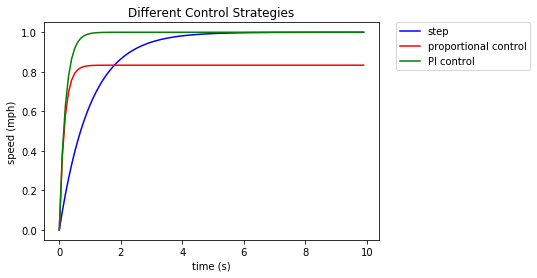

In [22]:
plt.plot(tCAR, yCAR, 'b', label="step")
plt.plot(tPROP, yPROP, 'r', label="proportional control")
plt.plot(tPI, yPI, 'g', label="PI control")
plt.title('Different Control Strategies')
plt.xlabel('time (s)')
plt.ylabel('speed (mph)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In the step control system, we do get to our reference speed, but we go there very slowly since we are gradually tapping on the gas. In the Proportional Control System, we get to close to where we want to go relatively slowly, but we have a large steady state error, since we chose $K = 5$, and thus our steady state error is around $\frac{1}{5}$, or 20%. With the PI Control, we both have a fast response and get rid of the steady state error, since we are integrating over error, or $\epsilon$, term. 

This is kind of how we actually drive. If you are careful, you drive slowly to your top speed. If you are more aggressive, you jam on the gas, and then let off slowly as your speed approaches the reference value. 